# EDA a partir de la API de MELI
### Exploración y análisis
<a id="top"></a>
Autor: Mathiews Flores Zavala

<p> En esta notebook, voy a explorar los resultados de las publicaciones de MELI meduante su API de acceso público. Y se proseguirá a obtener un dataset para trabajar a posteriori, y un análisis exploratorio de los datos</p>

## Tabla de Contenidos
1. <a href="#1">Data Wrangling</a>
* 1.1 <a href="#1.1">Importando librerías y datos</a>
* 1.2 <a href="#1.2">Explorando los datos </a>
* 1.3 <a href="#1.3">Armando el dataset</a>
* 1.4 <a href="#1.4">Analisis del dataset</a>
2. <a href="#2">Completar</a>
* 2.1 <a href='#2.1'>Completar</a>
3. <a href="#3">Preproceso de datos</a>
* 3.1 <a href='#3.1'>Separación de datos en Train y Test</a>
* 3.2 <a href='#3.2'>Variables Numéricas y Categóricas</a>
* 3.3 <a href='#3.3'>Normalización de Variables</a>

---
<a href="#top">Back to Index</a>
<a id="1"></a>
### 1) Data Wrangling
<a id="1.1"></a>
#### 1.1) Importando librerias y datos

In [311]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import time, sleep
import re

#from bs4 import BeautifulSoup

Consulto la API de Mercado Libre publica mediante búsquedas. En esta instacia me focalizaré en recopilar datos para componer una muestra de la población de publicaciones disponibles de la API de MELI

In [2]:
url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k'
result = requests.get(url)
type(result)

requests.models.Response

In [3]:
print('La conexión se logro con exito: ', str(result.status_code == 200))

La conexión se logro con exito:  True


In [4]:
# me fijo en el kas keys de contenido que hay, para darme una idea de lo que puedo obtener y lo que me interesa
data1 = result.json()
data1.keys()

dict_keys(['site_id', 'country_default_time_zone', 'query', 'paging', 'results', 'secondary_results', 'related_results', 'sort', 'available_sorts', 'filters', 'available_filters'])

In [5]:
data1['paging']

{'total': 3434, 'primary_results': 1000, 'offset': 0, 'limit': 50}

In [6]:
print( data1['paging']['total'] )
vector_data1 = list( range(0, data1['paging']['total'] , 50) )

3434


In [7]:
# verificamos la cantidad de registros entregados en la consulta
print('La cantidad de registros por consutla son ',str(len(data1['results'])))

La cantidad de registros por consutla son  50


La busqueda inicial arroja 1000 registros de un total de 3455 de los mismos, donde el límite esta en 50 datos por consulta.
Para no saturar el servicio con las consultas, se explorará inicialmente el contenido del que se dispone, posteriormente se extraera datos para armar un data set orientado hacia elementos digitales (televisores, telefonos, notebooks, tablets)

<a id="1.2"></a>
#### 1.2) Explorando los datos

In [8]:
# explioramos los resultados
data1['results'][1]

{'id': 'MLA905996538',
 'site_id': 'MLA',
 'title': 'Smart Tv Hyundai 50 4k Uhd Google Android ',
 'seller': {'id': 608846165,
  'permalink': 'http://perfil.mercadolibre.com.ar/MERCADOLIBRE+ELECTRONICA_AR',
  'registration_date': '2020-07-13T13:21:30.000-04:00',
  'car_dealer': False,
  'real_estate_agency': False,
  'tags': ['brand',
   'user_info_verified',
   'large_seller',
   'credits_profile',
   'messages_as_seller'],
  'seller_reputation': {'transactions': {'total': 613410,
    'canceled': 28335,
    'period': 'historic',
    'ratings': {'negative': 0.06, 'positive': 0.93, 'neutral': 0.01},
    'completed': 585075},
   'power_seller_status': 'platinum',
   'metrics': {'claims': {'rate': 0.0084, 'value': 1109, 'period': '60 days'},
    'delayed_handling_time': {'rate': 0, 'value': 0, 'period': '60 days'},
    'sales': {'period': '60 days', 'completed': 125242},
    'cancellations': {'rate': 0, 'value': 0, 'period': '60 days'}},
   'level_id': '5_green'}},
 'price': 49999,
 'pric

Observando la documentación, vemos algunas de los atributos de las publicaciones, como el *id* y *título* de cada una de ellas,
informacion del vendedor o *seller* (con su respectivo ID, y sitio en mercado Libre, su fecha de registro, entre otros).
Algunos valores interesantes de esta documentación consiste en la reputación del vendedor, ratings, entre otros.

Otros quizá resuleten no tan informativos, como *prices*, que además de contener algo de iformación redundante como *price, currency* contiene cierta metadata que puede no aportar mucho en una instancia temprana. De esta manera hay otros como *presentation, payment_method_prices*

In [9]:
# hago otra consulta
url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k&offset=340'
result2 = requests.get(url)
data2 = result2.json()

Se puede obtener hasta 1000 datos sin problemas, que corresponde a los primary_results, posterior a eso necesito el ID_USER para poder acceder a un código para mi url para acceder al resto de los datos. Por ahora voy a dejarlo en 2do plano.
Y realizaré consultas de hasta 1000 registros, siendo conciente que estos 1000 resultados estan inlfuenciados por el propio algoritmo del motor de búsqueda de MELI.

In [10]:
# exploramos los datos del primer dataset
df1 = pd.DataFrame(data1['results'])
df1

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.00,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.00,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.00,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.00,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.00,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}
5,MLA884683677,MLA,Smart Tv Samsung 50 4k Uhd 50tu7000,"{'id': 608846165, 'permalink': 'http://perfil....",75999.00,"{'id': 'MLA884683677', 'prices': [{'id': '154'...",None,ARS,250,500,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[brand_verified, extended_warranty_eligible, g...",NaN,True,6,{'id': 35713319}
6,MLA929210416,MLA,Smart Tv Philco 50 4k Pld50us21a,"{'id': 608846165, 'permalink': 'http://perfil....",49999.00,"{'id': 'MLA929210416', 'prices': [{'id': '16',...",None,ARS,1,50,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[extended_warranty_eligible, good_quality_pict...",NaN,True,7,NaN
7,MLA914384399,MLA,Chromecast With Google Tv De Voz 4k 8gb Sno...,"{'id': 82274172, 'permalink': 'http://perfil.m...",11400.00,"{'id': 'MLA914384399', 'prices': [{'id': '18',...",None,ARS,31,180,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA16233185,"[good_quality_picture, good_quality_thumbnail,...",True,True,8,NaN
8,MLA919581387,MLA,Smart Tv Tcl 50p715 Led 4k 50 100v/240v,"{'id': 608846165, 'permalink': 'http://perfil....",65999.00,"{'id': 'MLA919581387', 'prices': [{'id': '132'...",None,ARS,185,865,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16202534,"[ahora-12, extended_warranty_eligible, good_qu...",True,True,9,{'id': 35713319}
9,MLA878666563,MLA,Smart Tv Philips 6600 Series 50pud6654/77 Led ...,"{'id': 608846165, 'permalink': 'http://perfil....",68999.00,"{'id': 'MLA878666563', 'prices': [{'id': '198'...",None,ARS,644,2348,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA15699007,"[ahora-12, brand_verified, extended_warranty_e...",True,True,10,{'id': 35713319}


In [11]:
# conozco las columnas que posee
df1.columns

Index(['id', 'site_id', 'title', 'seller', 'price', 'prices', 'sale_price',
       'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode',
       'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail',
       'thumbnail_id', 'accepts_mercadopago', 'installments', 'address',
       'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'catalog_listing', 'use_thumbnail_id', 'order_backend',
       'differential_pricing'],
      dtype='object')

Para una instancia a futuro algunos de los campos más interesantes son:
* *installments* > *adress*
* *seller* > *seller_reputation* > *transactions*
* *tag* => se puede aplicar text mining para determinar como inlfuye en las ventas de la publicacion

In [85]:
# suando incluso el código de ID_USER, no se obteiene el resultado esperado
ID_USER = input("Ingrese su ID_USER otorgado por Mercado Libre") 
url = 'https://api.mercadolibre.com/users/$' +str('ID_USER') + '/MLA/search?search_type=scan'
result3 = requests.get(url)
data3 = result3.json()
data3

{'error': 'resource not found',
 'message': 'Si quieres conocer los recursos de la API que se encuentran disponibles visita el Sitio de Desarrolladores de MercadoLibre (http://developers.mercadolibre.com)'}

 <a id="1.3"></a>
#### 1.3) Armando el Dataset
En esta instancia continuaré con el proceso de extracción de datos para armar el dataset

Mediante la definicion de una funcion voy realizar las consultas a la API de MELI cada 15 seg, obteniendo 1000 resultados por busqueda.

En esta instancia, focalizare en ciertos elementos de electronica como tv, celulares, notebooks, tablets (elementos que más destaquen en las búsquedas o con una gran cantidad de publicaciones)

In [22]:
# voy a definir una función para realizar las consultas, y tomar el resultado y entregarlo como un dataset
def call_data(vector = [0,50], url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k' ):
    '''Funcion para llamar a la API de mercado libre con un resultado especifico, haciendo consultas de 50 en 50
    y guardandolas en un data frame'''
    t = len(vector)
    lista1 = [] #instancio una lista vacia
    for t in list(range( 0,len(vector),1 ) ):
        url_act = url + '&offset=' + str( vector[t] )
        #print(url_act) #para comprobar la direccion
        result = requests.get(url_act)
        if result2.status_code == 200:
            #lista2 = result.json()['results']
            lista1.extend( result.json()['results'] )
        else:
            print('hubo un error')
            df_rta = pd.DataFrame(lista1)  
        print(t, end="\r")
        sleep(15) #cada 15 segundos
        
    df_rta = pd.DataFrame(lista1)    
    return df_rta

In [23]:
df_tv = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k')

In [24]:
#veamos las dimensiones del data set
df_tv.shape

(1040, 33)

In [25]:
df_tv.to_csv('./data/data_tv_4k_1krows.csv', index= False)

In [26]:
df_tv.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}


In [28]:
df_cel = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=celular%20')

#df_cel.to_excel('./data/data_celular_1krows.xlsx', index= False)
df_cel.to_csv('./data/data_celular_1krows.csv', index= False)

In [29]:
df_tab = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=tablet%20')

df_tab.to_csv('./data/data_tablet_1krows.csv', index= False)

In [30]:
df_notebook = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=notebook%20')

df_notebook.to_csv('./data/data_notebook_1krows.csv', index= False)

In [ ]:
## solo en el caso de querer leer los archivos desde csv
#df_tv = pd.read_excel('./data/data_tv_4k_1krows.xlsx')
#df_cel = pd.read_excel('./data/data_celular_1krows.xlsx')
#df_notebook = pd.read_excel('./data/data_notebook_1krows.xlsx')
#df_tab = pd.read_excel('./data/data_tablet_1krows.xlsx')

#df_tv = pd.read_csv('./data/data_tv_4k_1krows.csv')
#df_cel = pd.read_csv('./data/data_celular_1krows.csv')
#df_notebook = pd.read_csv('./data/data_notebook_1krows.csv')
#df_tab = pd.read_csv('./data/data_tablet_1krows.csv')

Concatenamos los dataframes obtenidos hasta el momento como uno solo, concatenando uno detras del otro.

In [94]:
# concatenamos los datasets obtenidos hasta el momento
df = pd.concat([df_tv, df_cel, df_tab, df_notebook], axis = 0).reset_index(drop = True)

In [95]:
df

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,MLA871820328,MLA,Notebook Lenovo V15 Core I5 10ma Gen 1tb + Ssd...,"{'id': 131648529, 'permalink': 'http://perfil....",150985.0,"{'id': 'MLA871820328', 'prices': [{'id': '7', ...",None,ARS,1,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,None,"[brand_verified, extended_warranty_eligible, g...",NaN,False,46,{'id': 35713287}
4156,MLA900496858,MLA,"Notebook Hp 2021 Elite I7 10ma 40gb 17,3 2tb S...","{'id': 141336342, 'permalink': 'http://perfil....",398999.0,"{'id': 'MLA900496858', 'prices': [{'id': '6', ...",None,ARS,5000,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,None,"[loyalty_discount_eligible, brand_verified, go...",NaN,False,47,{'id': 35713287}
4157,MLA895870357,MLA,Notebook Bangho L5 Intel I7-10510u 8gb Ssd240 ...,"{'id': 192106606, 'permalink': 'http://perfil....",159000.0,"{'id': 'MLA895870357', 'prices': [{'id': '5', ...",None,ARS,1,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,MLA17328361,"[good_quality_picture, good_quality_thumbnail,...",NaN,False,48,{'id': 35713231}
4158,MLA866181995,MLA,Notebook Lenovo Ideapad 3 Intel I3 10th 8gb Ss...,"{'id': 82274172, 'permalink': 'http://perfil.m...",83999.0,"{'id': 'MLA866181995', 'prices': [{'id': '17',...",None,ARS,1,50,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,MLA16053932,"[good_quality_thumbnail, loyalty_discount_elig...",NaN,False,49,NaN


<a id="1.4"></a>
#### 1.4) Analisis del dataset

In [56]:
df.columns

Index(['index', 'id', 'site_id', 'title', 'seller', 'price', 'prices',
       'sale_price', 'currency_id', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'thumbnail_id', 'accepts_mercadopago', 'installments',
       'address', 'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'catalog_listing', 'use_thumbnail_id', 'order_backend',
       'differential_pricing'],
      dtype='object')

Al provenir transformar una lista de diccionario, que originalmente venía de una consulta tipo json, me encuentro con que algunas columnas contienen su información en formato dic. Vamos a explorarla, y de paso, ver que información se puede obtener sin tener que aplicar text mining en esta instancia

In [97]:
# exploro la cantidad de nulos y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4160 non-null   object 
 1   site_id               4160 non-null   object 
 2   title                 4160 non-null   object 
 3   price                 4160 non-null   float64
 4   prices                4160 non-null   object 
 5   sale_price            0 non-null      object 
 6   currency_id           4160 non-null   object 
 7   available_quantity    4160 non-null   int64  
 8   sold_quantity         4160 non-null   int64  
 9   buying_mode           4160 non-null   object 
 10  listing_type_id       4160 non-null   object 
 11  stop_time             4160 non-null   object 
 12  condition             4160 non-null   object 
 13  permalink             4160 non-null   object 
 14  thumbnail             4160 non-null   object 
 15  thumbnail_id         

In [107]:
# 
df.describe()

,price,available_quantity,sold_quantity,original_price,official_store_id,order_backend,id
count,4.160000e+03,4160.000000,4160.000000,709.000000,621.000000,4160.000000,4.160000e+03
mean,7.448659e+04,156.363702,50.757212,75526.043554,1090.275362,25.497356,2.081767e+08
std,3.707253e+05,1515.758183,343.723400,64331.915747,827.029270,14.431171,1.686220e+08
min,3.300000e+01,1.000000,0.000000,1600.000000,47.000000,1.000000,1.048590e+05
25%,1.500000e+04,1.000000,1.000000,20899.000000,229.000000,13.000000,8.252185e+07
50%,4.995850e+04,1.000000,5.000000,59999.000000,1205.000000,25.500000,1.727533e+08
75%,9.310338e+04,3.000000,25.000000,109999.000000,1938.000000,38.000000,2.848246e+08
max,2.335000e+07,50000.000000,10459.000000,395999.000000,2588.000000,50.000000,8.006795e+08


Para este caso, cabe resaltar que *id, order_backend, official_store_id* si bien son numericos no aportan explicaciones al analisis de datos.
En cuanto al resto de las variables, como *price, available_quantity, sold_quantity, original_price* se veran influenciadas por los tipos de productos, y a su vez por las carateristicas del mismo

In [74]:
# tipos de dominios, para identificar si la busqueda me devolvio efectivamente los cambos de las busquedas
df.domain_id.value_counts()

MLA-NOTEBOOKS                                 1050
MLA-TABLETS                                   1040
MLA-CELLPHONES                                1030
MLA-TELEVISIONS                                827
MLA-STREAMING_MEDIA_DEVICES                    110
MLA-TV_REMOTE_CONTROLS                          48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         43
MLA-TV_AND_MONITOR_MOUNTS                        9
MLA-TV_REMOTE_CONTROL_COVERS                     1
MLA-TV_RECEIVERS_AND_DECODERS                    1
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       1
Name: domain_id, dtype: int64

In [170]:
(df.groupby('domain_id')['price'].agg(['mean','median','std','max','min']).round(2)).sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-NOTEBOOKS,116546.39,107387.00,54240.77,469999.0,1000.00
MLA-TELEVISIONS,113612.55,76373.00,137005.58,1998000.0,33.00
MLA-TABLETS,53702.18,15998.50,724472.94,23350000.0,65.00
MLA-CELLPHONES,35290.52,23749.00,38514.98,389990.0,50.00
MLA-STREAMING_MEDIA_DEVICES,10610.85,10199.50,4871.46,49400.0,5259.00
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS,6999.00,6999.00,NaN,6999.0,6999.00
MLA-TV_RECEIVERS_AND_DECODERS,5869.00,5869.00,NaN,5869.0,5869.00
MLA-TV_AND_MONITOR_MOUNTS,2335.72,499.99,3344.27,9380.0,299.99
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,1544.69,1299.00,1151.53,3990.0,199.91


Las notebooks representan aquellos productos que tienen el mayor precio promedio (independientemente de la gama del articulo)
En tanto que los celulares tienen el menor precio medio.
La diferencia entre la media y la mediana en estos casos se debe, ademas de la presencia de outliers en los datos, dependera de las carateristicas y la cantidad de productos para las distintas gamas.

Tambien podemos ver que los maximos hay valores hasta 2 ordenedes de magnitud por encima del orden de la media y la mediana. En el caso de Tablets por ejemplo, la media y mediana estan en el orden de 1e4, en tanto que el maximo valor esta en el orden de 1e7; otro sucede con los televisores.


Aquellos que tienen std = NaN, son aquellos elementos que son unicos, ya que temino dividinedo por 0 (n-1).
Estos son productos que se colaron el la busqueda de television, donde los resultados entregados no fueron tan precisos como con tablets, notebooks y celulares.

domain_id = ['MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS', 'MLA-TV_RECEIVERS_AND_DECODERS', 'MLA-TV_REMOTE_CONTROL_COVERS']



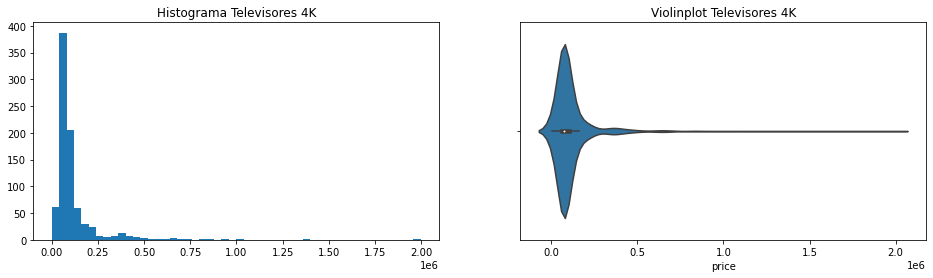

In [160]:
plt.figure(figsize = (16, 4))

ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-TELEVISIONS']
plt.hist(data=data_2plot, x='price', bins=50)
plt.title('Histograma Televisores 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10)
plt.title('Violinplot Televisores 4K')
plt.show()

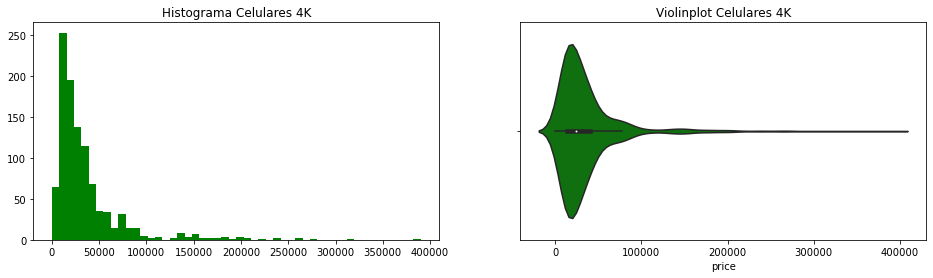

In [163]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-CELLPHONES']
plt.hist(data=data_2plot, x='price', bins=50, color= 'green')
plt.title('Histograma Celulares 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10, color= 'green')
plt.title('Violinplot Celulares 4K')
plt.show()

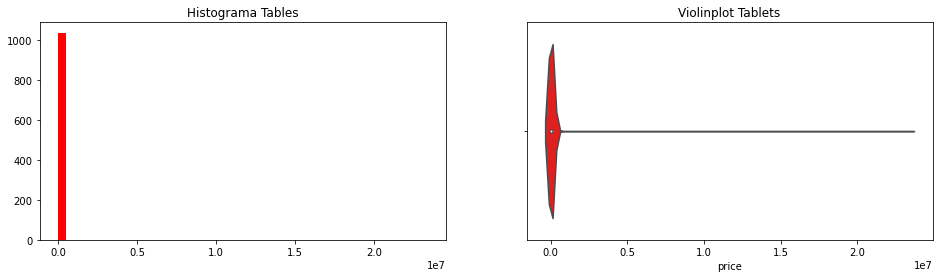

In [174]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-TABLETS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Violinplot Tablets')
plt.show()

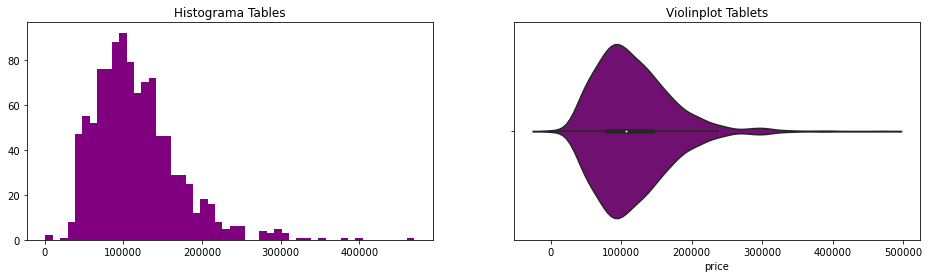

In [173]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-NOTEBOOKS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Violinplot Tablets')
plt.show()

In [177]:
(df.groupby('domain_id')['sold_quantity'].agg(['mean','median','std','max','min']).round(2)).\
                        sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-STREAMING_MEDIA_DEVICES,94.85,50.0,134.57,623,1
MLA-CELLPHONES,91.97,5.0,537.62,10459,0
MLA-TV_REMOTE_CONTROLS,89.56,37.5,137.68,500,4
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,65.19,5.0,105.82,500,2
MLA-TV_AND_MONITOR_MOUNTS,62.44,25.0,83.82,250,3
MLA-TV_REMOTE_CONTROL_COVERS,50.00,50.0,NaN,50,50
MLA-TABLETS,45.17,2.0,332.77,9924,0
MLA-NOTEBOOKS,29.32,5.0,74.09,706,0
MLA-TELEVISIONS,24.79,0.0,284.00,7388,0


En cuanto a las unidades vendidas por categorías se puede apreciar que la media ronda el mismo orden para los distintos productos.
Sin embargo puede llegar a ser muy dispar las ventas que se producen para las distintas publicaciones y vendedores, nos podemos dar cuenta de ello debido a las medianas cuando son muy pequeñas respecto de su media, y el maximo es bastante mayor.

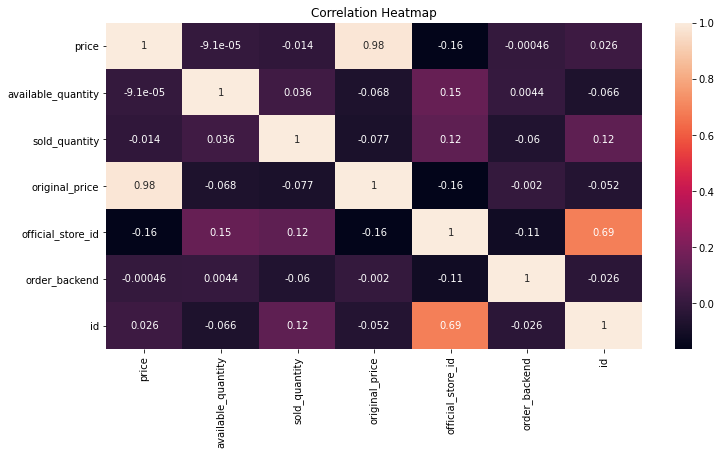

In [181]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in df.select_dtypes(include=['number']).columns]
sns.heatmap(df[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

De los valores numericos, ignorando *id, order_backend, official_store_id* hay una fuerte corelacion entre price y original_price, y no es 1 directamente debido a que existen descuento aplicado, de lo contrario seria null en este caso.

Veamos cuantos productos tienen descuentos en esta muestra:

In [72]:
(df.original_price.isnull()).value_counts()

True     3451
False     709
Name: original_price, dtype: int64

In [73]:
# cuantos productos generales tienen descuento, y que % representa del total
print("La cantidad de productos con descuento es {}, y representa el {} %".format(
        (df.original_price.isnull()).value_counts()[0] ,
        ((df.original_price.isnull()).value_counts()[0] / len(df))
        )
     )

La cantidad de productos con descuento es 709, y representa el 0.1704326923076923 %


In [303]:
categoria_productos = {'televisores':'MLA-TELEVISIONS','celulares':'MLA-CELLPHONES','tablets':'MLA-TABLETS',\
                       'notebooks':'MLA-NOTEBOOKS'}
descuentos_productos = pd.DataFrame(categoria_productos, index = ['domain_id']).T
for key in categoria_productos:
    #auxi = re.sub('MLA-', '', domain)
    cant_prod_cdescuento = (df[df['domain_id'] == categoria_productos[key] ].original_price.isnull()).value_counts()[0]
    cant_prod_categoria = len(df[df['domain_id'] == categoria_productos[key] ])
    print("La cantidad de ", str(key) ," con descuento es {}, de un total de {} y representa el {} %".format(
            cant_prod_cdescuento,
            cant_prod_categoria,
            round((cant_prod_cdescuento /cant_prod_categoria )*100,2)
            )
         )
    #asignacion de cantidad de descuentos
    descuentos_productos.loc[key,'ratio_prod_wdiscount'] = (cant_prod_cdescuento /cant_prod_categoria )
    

La cantidad de  televisores  con descuento es 99, de un total de 827 y representa el 11.97 %
La cantidad de  celulares  con descuento es 146, de un total de 1030 y representa el 14.17 %
La cantidad de  tablets  con descuento es 172, de un total de 1040 y representa el 16.54 %
La cantidad de  notebooks  con descuento es 270, de un total de 1050 y representa el 25.71 %


Los productos con mayor cantidad de descuentos son las notebooks, en tanto que los que tienen menor ratio de descuentos son los televisores, basado en nuestra muestra.

In [289]:
# veamos como nos va con los descuentos
comparacion_descuentos = df[df['original_price'].notnull()][['price','original_price','domain_id']].copy()
# verifico que todos los datos sean fiables, debe coincidir con la cantidad de descuentos.
print('Cantidad de valores con descuento :',
      str( (comparacion_descuentos.original_price > comparacion_descuentos.price).sum() ))
print('Cantidad de valores sin descuento:',
      str( (comparacion_descuentos.original_price == comparacion_descuentos.price).sum() ))

Cantidad de valores con descuento : 704
Cantidad de valores sin descuento: 5


Algo que podemos notar es que no deberian figurar valores donde *original_price == price*, ya que es una condicion de este dataset. En estos casos pudo haber siso un error durante la carga.

In [309]:
# Para conocer el promedio de descuestos necesito solamente considerar aquellos que realmente tienen descuento
comparacion_descuentos = comparacion_descuentos[\
                        comparacion_descuentos['original_price']>comparacion_descuentos['price']]
# calculo el descuento general independientemente de la categoria
print('El porcentaje de descuento promedio para los productos en oferta(con descuentos) es de {}%'.format(\
    round(( (comparacion_descuentos.original_price.sum()-comparacion_descuentos.price.sum())/\
    comparacion_descuentos.original_price.sum())*100, 2) ))
# calculo el descuento para las categorias de interes
for key in categoria_productos:
    descuento = (comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].original_price.sum()-\
                 comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].price.sum() )/\
                 comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].original_price.sum()
    print('El porcentaje de descuento promedio de la categoria ', str(key) ,' es de {}%'.format(
            round(descuento*100,2)
            )
         )
    #asignacion de cantidad de descuentos
    descuentos_productos.loc[key,'prom_discount'] = descuento

El porcentaje de descuento promedio para los productos en oferta(con descuentos) es de 15.24%
El porcentaje de descuento promedio de la categoria  televisores  es de 12.88%
El porcentaje de descuento promedio de la categoria  celulares  es de 13.45%
El porcentaje de descuento promedio de la categoria  tablets  es de 20.14%
El porcentaje de descuento promedio de la categoria  notebooks  es de 15.58%


In [310]:
descuentos_productos

,domain_id,ratio_prod_wdiscount,prom_discount
televisores,MLA-TELEVISIONS,0.119710,0.128813
celulares,MLA-CELLPHONES,0.141748,0.134494
tablets,MLA-TABLETS,0.165385,0.201432
notebooks,MLA-NOTEBOOKS,0.257143,0.155849


In [338]:
x_2plot = np.array(descuentos_productos.index)
y_2plot1 = np.array(descuentos_productos.iloc[:,1].apply(lambda x: round(x,3)))
y_2plot2 = np.array(descuentos_productos.iloc[:,2].apply(lambda x: round(x,3)))

xcoord4 = range(0,4)
xi = range(len(xcoord4))
yi = range

annotations1 = [dict(x=xi-0.2,y=yi ,text=str(yi*100)+'%',xanchor='auto',yanchor='bottom',showarrow=False,
                    ) for xi, yi in zip(xcoord4, y_2plot1)]

annotations2 = [dict(x=xi+0.2,y=yi ,text=str(yi*100)+'%',xanchor='auto',yanchor='bottom',showarrow=False,
                    ) for xi, yi in zip(xcoord4, y_2plot2)]

annotations = annotations1 + annotations2

trace1 = go.Bar(x=x_2plot, y=y_2plot1, textposition='auto', name='% prod. con descuento', marker_color='#1f77b4',)
trace2 = go.Bar(x=x_2plot, y=y_2plot2, textposition='auto', name='Descuento promedio', marker_color='#00EA65')

data = [trace1, trace2]
layout = go.Layout(barmode='group',annotations=annotations, xaxis_tickangle=-45)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title='Porcentaje de productos con descuentos y descuento promedio por categoria'\
                  ,plot_bgcolor= 'whitesmoke',autosize=True)
fig.update_yaxes(tickformat=',.0%',range=[0.0,0.35], constrain="domain")
fig

In [ ]:
# reemplazar los nulos por 0, para no conservar nulos en esa area


In [57]:
# quiero explorar el contenido del diccionario que contienen algunas columnas
pd.DataFrame(list(df.seller))

,id,permalink,registration_date,car_dealer,real_estate_agency,tags,eshop,seller_reputation
0,185702920,http://perfil.mercadolibre.com.ar/ITECOM+DIGITAL,2015-06-16T14:24:23.000-04:00,False,False,"[normal, user_info_verified, credits_profile, ...","{'nick_name': 'ITECOM DIGITAL', 'eshop_rubro':...","{'transactions': {'total': 74089, 'canceled': ..."
1,608846165,http://perfil.mercadolibre.com.ar/MERCADOLIBRE...,2020-07-13T13:21:30.000-04:00,False,False,"[brand, user_info_verified, large_seller, cred...",NaN,"{'transactions': {'total': 613410, 'canceled':..."
2,608846165,http://perfil.mercadolibre.com.ar/MERCADOLIBRE...,2020-07-13T13:21:30.000-04:00,False,False,"[brand, user_info_verified, large_seller, cred...",NaN,"{'transactions': {'total': 613410, 'canceled':..."
3,76104882,http://perfil.mercadolibre.com.ar/COMPUCOM2004,2004-10-04T14:40:10.000-04:00,False,False,"[normal, user_info_verified, eshop, credits_pr...","{'nick_name': 'COMPUCOM2004', 'eshop_rubro': N...","{'transactions': {'total': 15765, 'canceled': ..."
4,608846165,http://perfil.mercadolibre.com.ar/MERCADOLIBRE...,2020-07-13T13:21:30.000-04:00,False,False,"[brand, user_info_verified, large_seller, cred...",NaN,"{'transactions': {'total': 613410, 'canceled':..."
...,...,...,...,...,...,...,...,...
4155,131648529,http://perfil.mercadolibre.com.ar/PCCENTERCOMP...,2013-01-10T09:50:15.000-04:00,False,False,"[normal, user_info_verified, eshop, medium_sel...","{'nick_name': 'PCCENTERCOMPUTERS', 'eshop_rubr...","{'transactions': {'total': 24796, 'canceled': ..."
4156,141336342,http://perfil.mercadolibre.com.ar/TODOTEKNO+AR...,2013-07-02T19:42:27.000-04:00,False,False,"[normal, user_info_verified, credits_profile, ...",NaN,"{'transactions': {'total': 1229, 'canceled': 5..."
4157,192106606,http://perfil.mercadolibre.com.ar/GN+POINT,2015-09-09T15:17:17.000-04:00,False,False,"[normal, user_info_verified, eshop, mshops, cr...","{'nick_name': 'GN POINT', 'eshop_rubro': None,...","{'transactions': {'total': 776, 'canceled': 29..."
4158,82274172,http://perfil.mercadolibre.com.ar/BH+COMPUTACION,2005-07-04T10:41:06.000-04:00,False,False,"[normal, user_info_verified, credits_priority_...","{'nick_name': 'BH COMPUTACION', 'eshop_rubro':...","{'transactions': {'total': 27138, 'canceled': ..."


In [58]:
def extrac_new_DF_from_colum(df_2work, column_2work, option =1):
    '''Debido a la naturaleza de extraccion de datos de las APIs para evitar colapsar el servicio, en oportunidades
    hay diccionarios en alguna de las columnas al tratarse de archivos tipo json()
    con esta funcion indicamos el DF, y la columna de interes para devolver un nuevo dataframe
    df_2work => DataFrame de pandas
    colum_2work => 'string
    option = 1 o 2 devuelve un dataframe con y sin el atributo column_2work en el dataframe'''
    if option == 1:
        return pd.DataFrame( list(df_2work[column_2work]) ) #para probar, pero sin dropear la columna
    elif option == 2:
        # alternativa para expandir el dataframe en aquellas columnas que se duplican, me ahorro de pasos
        # con pop extraigola columna de interes para no dropear en otro paso
        return pd.concat([df_2work.drop([column_2work], axis=1), df_2work[column_2work].apply(pd.Series)], axis=1)


In [96]:
df = extrac_new_DF_from_colum(df, 'seller', 2)

Uno de los topicos interesantes es la reputacion del vendedor, *seller_reputation* 

In [98]:
df2 = extrac_new_DF_from_colum(df, 'seller_reputation', 1)

In [99]:
df2

,transactions,power_seller_status,metrics,level_id,protection_end_date,real_level
0,"{'total': 74089, 'canceled': 4248, 'period': '...",platinum,"{'claims': {'rate': 0.0148, 'value': 185, 'per...",5_green,NaN,NaN
1,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
2,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
3,"{'total': 15765, 'canceled': 605, 'period': 'h...",platinum,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN
4,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
...,...,...,...,...,...,...
4155,"{'total': 24796, 'canceled': 1047, 'period': '...",platinum,"{'claims': {'rate': 0.0153, 'value': 49, 'peri...",5_green,NaN,NaN
4156,"{'total': 1229, 'canceled': 51, 'period': 'his...",gold,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN
4157,"{'total': 776, 'canceled': 29, 'period': 'hist...",gold,"{'claims': {'rate': 0, 'value': 0, 'period': '...",5_green,NaN,NaN
4158,"{'total': 27138, 'canceled': 995, 'period': 'h...",platinum,"{'claims': {'rate': 0.0088, 'value': 30, 'peri...",5_green,NaN,NaN


In [100]:
df2 = extrac_new_DF_from_colum(df2, 'transactions', 2)

In [101]:
df2.head()

,power_seller_status,metrics,level_id,protection_end_date,real_level,total,canceled,period,ratings,completed
0,platinum,"{'claims': {'rate': 0.0148, 'value': 185, 'per...",5_green,NaN,NaN,74089,4248,historic,"{'negative': 0.02, 'positive': 0.96, 'neutral'...",69841
1,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075
2,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075
3,platinum,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN,15765,605,historic,"{'negative': 0, 'positive': 0.99, 'neutral': 0...",15160
4,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075


In [104]:
df2 = extrac_new_DF_from_colum(df2, 'ratings', 2)
df2 = extrac_new_DF_from_colum(df2, 'metrics', 2)

In [105]:
df2

,power_seller_status,level_id,protection_end_date,real_level,total,canceled,period,completed,negative,positive,neutral,claims,delayed_handling_time,sales,cancellations
0,platinum,5_green,NaN,NaN,74089,4248,historic,69841,0.02,0.96,0.02,"{'rate': 0.0148, 'value': 185, 'period': '60 d...","{'rate': 0.0152, 'value': 181, 'period': '60 d...","{'period': '60 days', 'completed': 11792}","{'rate': 0.003, 'value': 38, 'period': '60 days'}"
1,platinum,5_green,NaN,NaN,613410,28335,historic,585075,0.06,0.93,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}"
2,platinum,5_green,NaN,NaN,613410,28335,historic,585075,0.06,0.93,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}"
3,platinum,5_green,NaN,NaN,15765,605,historic,15160,0.00,0.99,0.01,"{'rate': 0, 'value': 1, 'period': '60 days'}","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 2364}","{'rate': 0, 'value': 0, 'period': '60 days'}"
4,platinum,5_green,NaN,NaN,613410,28335,historic,585075,0.06,0.93,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,platinum,5_green,NaN,NaN,24796,1047,historic,23749,0.01,0.97,0.02,"{'rate': 0.0153, 'value': 49, 'period': '60 da...","{'rate': 0.0033, 'value': 10, 'period': '60 da...","{'period': '60 days', 'completed': 3090}","{'rate': 0.0031, 'value': 10, 'period': '60 da..."
4156,gold,5_green,NaN,NaN,1229,51,historic,1178,0.00,0.99,0.01,"{'rate': 0, 'value': 1, 'period': '60 days'}","{'rate': 0.1262, 'value': 13, 'period': '60 da...","{'period': '60 days', 'completed': 207}","{'rate': 0, 'value': 1, 'period': '60 days'}"
4157,gold,5_green,NaN,NaN,776,29,historic,747,0.03,0.97,0.00,"{'rate': 0, 'value': 0, 'period': '60 days'}","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 176}","{'rate': 0, 'value': 0, 'period': '60 days'}"
4158,platinum,5_green,NaN,NaN,27138,995,historic,26143,0.01,0.97,0.02,"{'rate': 0.0088, 'value': 30, 'period': '60 da...","{'rate': 0.0069, 'value': 23, 'period': '60 da...","{'period': '60 days', 'completed': 3286}","{'rate': 0.0046, 'value': 16, 'period': '60 da..."
